## Crime in Austin

In [10]:
#imports & global file
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np
import os
import sys
import folium
from folium import plugins
import pandas as pd
import seaborn as sns
import itertools
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

df = pd.read_csv("Crime_Reports.csv")
len(df)

2447554

These are our imports, they will be what packages we use. Next, we will analyze data types and the head of the data.

In [11]:
df.dtypes


Incident Number                  int64
Highest Offense Description     object
Highest Offense Code             int64
Family Violence                 object
Occurred Date Time              object
Occurred Date                   object
Occurred Time                  float64
Report Date Time                object
Report Date                     object
Report Time                    float64
Location Type                   object
Address                         object
Zip Code                       float64
Council District               float64
APD Sector                      object
APD District                    object
PRA                             object
Census Tract                   float64
Clearance Status                object
Clearance Date                  object
UCR Category                    object
Category Description            object
X-coordinate                   float64
Y-coordinate                   float64
Latitude                       float64
Longitude                

In [12]:
df.head()


,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time,...,Census Tract,Clearance Status,Clearance Date,UCR Category,Category Description,X-coordinate,Y-coordinate,Latitude,Longitude,Location
0,20072790876,DISTURBANCE - OTHER,3401,N,10/05/2007 11:00:00 PM,10/05/2007,2300.0,10/06/2007 11:46:00 AM,10/06/2007,1146.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20065065520,FRAUD - OTHER,1199,N,11/14/2006 12:00:00 AM,11/14/2006,0.0,11/14/2006 12:00:00 AM,11/14/2006,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20232790155,BURGLARY NON RESIDENCE,502,N,10/06/2023 02:31:00 AM,10/06/2023,231.0,10/06/2023 02:58:00 AM,10/06/2023,258.0,...,416.0,N,10/11/2023,220,Burglary,3131257.0,10104351.0,30.359323,-97.686617,"(30.35932343, -97.68661703)"
3,2003421480455,CUSTODY ARREST TRAFFIC WARR,3722,N,05/28/2003 08:16:00 AM,05/28/2003,816.0,05/28/2003 08:16:00 AM,05/28/2003,816.0,...,NaN,N,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
4,20052602038,DOC UNREASONABLE NOISE,2405,N,NaN,09/17/2005,NaN,09/17/2005 09:45:00 PM,09/17/2005,2145.0,...,NaN,NaN,10/17/2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Next, we will convert our report and occured date times to be that of datetime objects, dropping the columns we wont need.

In [13]:

# date time conversions
df['report_dt'] = pd.to_datetime(df['Report Date Time'], format = '%m/%d/%Y %I:%M:%S %p')
df['occurred_dt'] = pd.to_datetime(df['Occurred Date Time'], format ='%m/%d/%Y %I:%M:%S %p')

df.drop(['Report Date Time', 'Occurred Date Time', 'Report Date', 'Report Time', 'Occurred Date', 'Occurred Time'], axis = 1, inplace = True)




We arent interested where it is null, drop those rows.

In [14]:
df = df[df['report_dt'].isnull() == False]
df = df[df['occurred_dt'].isnull() == False]


## Graphs

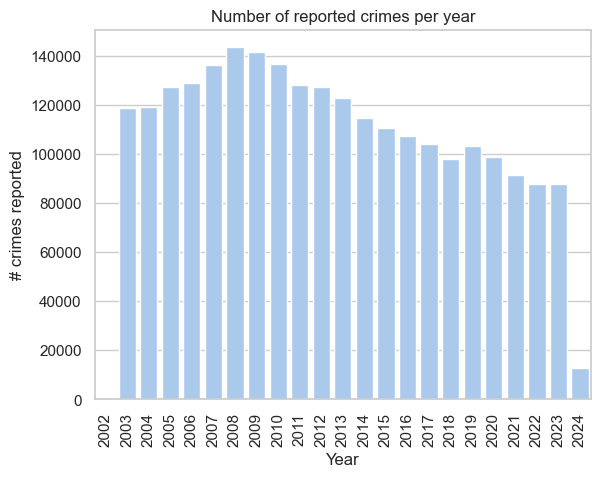

In [15]:
crimes_per_year = df['report_dt'].dt.year.value_counts().sort_index()


sns.set(style="whitegrid")
sns.set_color_codes("pastel")

g = sns.barplot(x=crimes_per_year.index, y=crimes_per_year.values,color='b')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set(xlabel='Year', ylabel='# crimes reported')
plt.title('Number of reported crimes per year')
plt.show()

There's only one row in the dataset for 2002. Looks like there was a peak in crimes reported in 2008 but since then there's a steady decline. 2024 Also contains a small amount of crimes due to how early it is in the year.

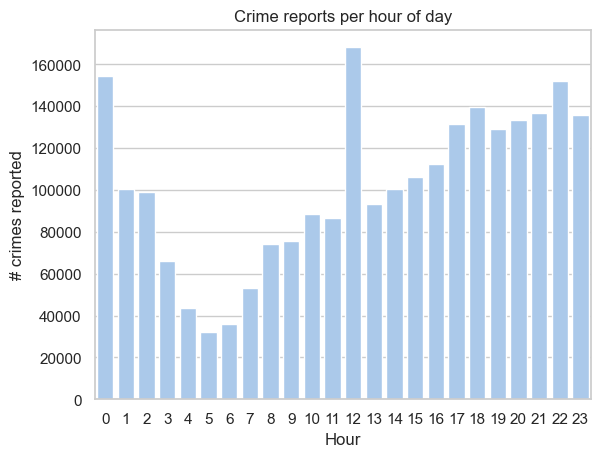

In [16]:
crimes_per_tod = df['occurred_dt'].dt.hour.value_counts().sort_index()
g = sns.barplot(x=crimes_per_tod.index, y=crimes_per_tod.values, color='b')
g.set(xlabel='Hour', ylabel='# crimes reported')
plt.title('Crime reports per hour of day')
plt.show()

It appears that the peak time for crimes is noon. Other than that it decreases at 1pm but steadily climbs untill it drops again after midnight.

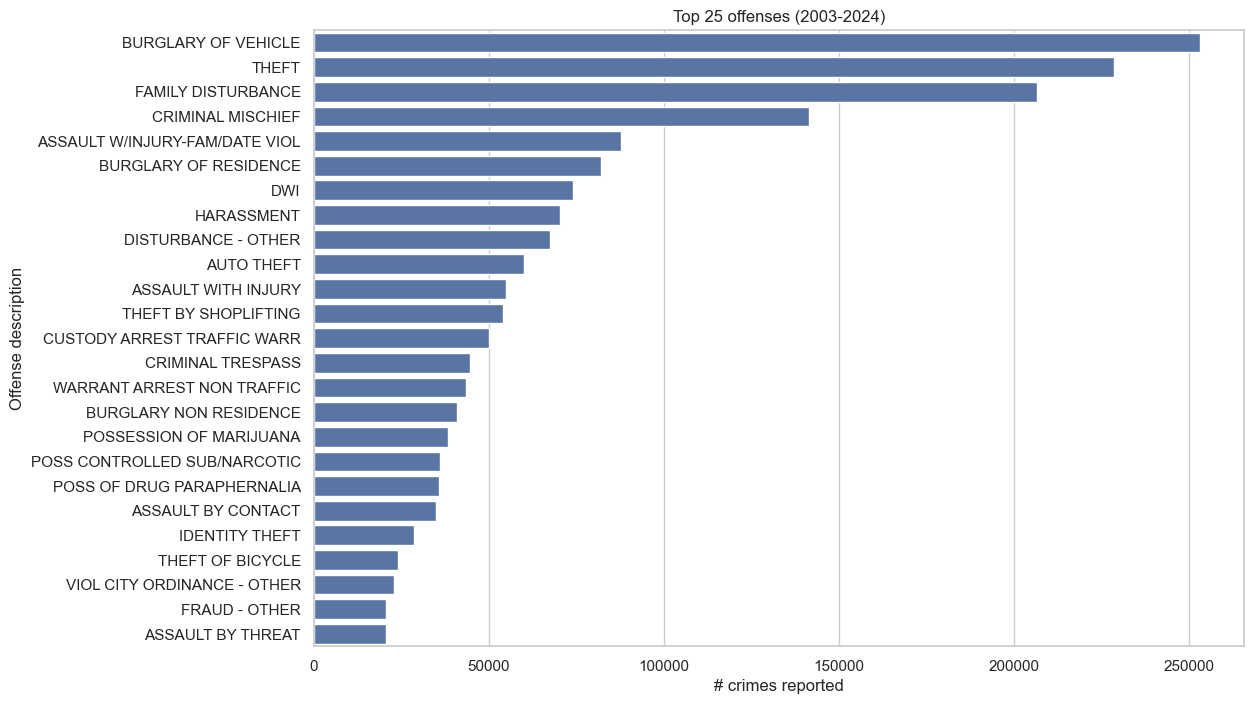

In [17]:
top_crimes = df['Highest Offense Description'].value_counts().head(25)
sns.set(rc={'figure.figsize':(12,8)},style="whitegrid")
g = sns.barplot(y=top_crimes.index, x=top_crimes.values,color='b')
g.set(xlabel='# crimes reported', ylabel='Offense description')
plt.title('Top 25 offenses (2003-2024)')
plt.show()

Top crime in austin is vehicle theft, which if followed by theft.

Next, we can use the Latitude and Longitude values to map where such crimes are most frequent.

For this, lets look at criminal trespassing and DWI, especially due to the ammount of lives those under the influence take every year. For the year, we will use last year, 2023.

In [18]:
trespassing = df[(df['Latitude'].isnull() == False) 
                  & (df['Longitude'].isnull() == False)
                 & (df['Highest Offense Description'] == 'CRIMINAL TRESPASS')
                 & (df['report_dt'].dt.year == 2023)][['Latitude','Longitude']]

influence = df[(df['Latitude'].isnull() == False) 
                  & (df['Longitude'].isnull() == False)
                 & (df['Highest Offense Description'] == 'DWI')
                 & (df['report_dt'].dt.year == 2023)][['Latitude','Longitude']]

In [19]:
map0 = folium.Map(location=[30.285516,-97.736753 ],tiles='OpenStreetMap', zoom_start=11)
map0.add_child(plugins.HeatMap(trespassing[['Latitude', 'Longitude']].values, radius=10))
map0

In [20]:
map1 = folium.Map(location=[30.285516,-97.736753 ],tiles='OpenStreetMap', zoom_start=11)
map1.add_child(plugins.HeatMap(influence[['Latitude', 'Longitude']].values, radius=15))
map1

Using these maps we can see heat indexes for where crime occurs the most. It seems around East 7th Street is where crime occurs the most, but at least using the map for DWI we can find areas to avoid drivers under the influence. Such data can be used even further to create applications to route drivers on safe paths to their destination (according to historical data)

In [37]:
# random forest classifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the dataset
df = pd.read_csv("Crime_Reports.csv")

# Filter the dataset for the year 2024
df['occurred_dt'] = pd.to_datetime(df['Occurred Date Time'], errors='coerce')
df = df[df['occurred_dt'].dt.year == 2024]

# Selecting features and the target variable
features = df[['Latitude', 'Longitude']].fillna(0)  # Example of handling NaN by filling with 0
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['Highest Offense Description'])

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, y_encoded, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Predictions
predictions = rf.predict(X_test_scaled)
unique_labels = np.unique(np.concatenate((y_test, predictions)))
target_names_for_pred = label_encoder.inverse_transform(unique_labels)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions, target_names=target_names_for_pred, labels=unique_labels))




Accuracy: 0.13293566254793354
                                               precision    recall  f1-score   support

                                 ABUSE OF 911       0.60      0.60      0.60         5
               AGG ASLT ENHANC STRANGL/SUFFOC       0.00      0.00      0.00         2
                  AGG ASLT STRANGLE/SUFFOCATE       0.05      0.04      0.04        28
                                  AGG ASSAULT       0.05      0.04      0.04        27
                AGG ASSAULT FAM/DATE VIOLENCE       0.00      0.00      0.00        13
                 AGG ASSAULT ON PEACE OFFICER       0.00      0.00      0.00         0
                AGG ASSAULT ON PUBLIC SERVANT       0.00      0.00      0.00         1
                   AGG ASSAULT WITH MOTOR VEH       0.00      0.00      0.00         1
                               AGG KIDNAPPING       0.00      0.00      0.00         1
                AGG PROMOTION OF PROSTITUTION       0.00      0.00      0.00         1
            

In [36]:
# KNN

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import numpy as np

# Load the dataset
df = pd.read_csv("Crime_Reports.csv")

# Convert 'Occurred Date Time' to datetime and create the datetime components
df['occurred_dt'] = pd.to_datetime(df['Occurred Date Time'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

# Extract datetime components
df['Year'] = df['occurred_dt'].dt.year
df['Month'] = df['occurred_dt'].dt.month
df['Day'] = df['occurred_dt'].dt.day
df['Hour'] = df['occurred_dt'].dt.hour

# Drop rows where any datetime component is NaN
df.dropna(subset=['Year', 'Month', 'Day', 'Hour'], inplace=True)

# Selecting features and the target variable
features = df[['Year', 'Month', 'Day', 'Hour', 'Latitude', 'Longitude']].fillna(0)  # Fill NaNs in Latitude and Longitude if they exist
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['Highest Offense Description'])

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, y_encoded, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the KNN model
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(X_train_scaled, y_train)

# Predictions
predictions = knn.predict(X_test_scaled)

unique_labels = np.unique(np.concatenate((y_test, predictions)))
target_names_for_pred = label_encoder.inverse_transform(unique_labels)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions, target_names=target_names_for_pred, labels=unique_labels))


Accuracy: 0.06885005434294073
                                               precision    recall  f1-score   support

                       ABANDONED REFRIGERATOR       0.17      1.00      0.29         1
                                 ABUSE OF 911       0.01      0.03      0.01        37
                              ABUSE OF CORPSE       0.00      0.00      0.00         1
                   ABUSE OF OFFICIAL CAPACITY       0.00      0.00      0.00         7
               AGG ASLT ENHANC STRANGL/SUFFOC       0.00      0.01      0.00       204
                  AGG ASLT STRANGLE/SUFFOCATE       0.01      0.02      0.01      1592
               AGG ASLT W/MOTOR VEH FAM/DAT V       0.00      0.00      0.00       153
                                  AGG ASSAULT       0.01      0.04      0.02      3606
                AGG ASSAULT BY PUBLIC SERVANT       0.08      0.50      0.14         2
                AGG ASSAULT FAM/DATE VIOLENCE       0.01      0.02      0.01      1887
            

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Load the dataset
df = pd.read_csv("Crime_Reports.csv")

# Filter for the year 2024 and preprocess data as necessary
df['occurred_dt'] = pd.to_datetime(df['Occurred Date Time'], errors='coerce')
df = df[df['occurred_dt'].dt.year == 2024]
df['Year'] = df['occurred_dt'].dt.year
df['Month'] = df['occurred_dt'].dt.month
df['Day'] = df['occurred_dt'].dt.day
df['Hour'] = df['occurred_dt'].dt.hour

features = df[['Year', 'Month', 'Day', 'Hour', 'Latitude', 'Longitude']].fillna(0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['Highest Offense Description'])

X_train, X_test, y_train, y_test = train_test_split(features, y_encoded, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid for RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Use the best model to make predictions
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_scaled)

# Dynamic target names to match unique labels in test set predictions
unique_labels = np.unique(np.concatenate((y_test, predictions)))
target_names_for_pred = label_encoder.inverse_transform(unique_labels)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions, target_names=target_names_for_pred, labels=unique_labels))


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2,

WORK IN PROGRESS - ADD MORE: 
KNN - Accuracy of 0.06
RandomForrest - Accuracy of 0.13
W/ hyper parameters: accuracy                           0.14      2347
                                    macro avg       0.02      0.02      0.02      2347
                                 weighted avg       0.06      0.14      0.07      2347

Best score: 0.14715036875561427
Accuracy: 0.13634426927993182

so far by the looks of it we will have to maybe drop parameters?

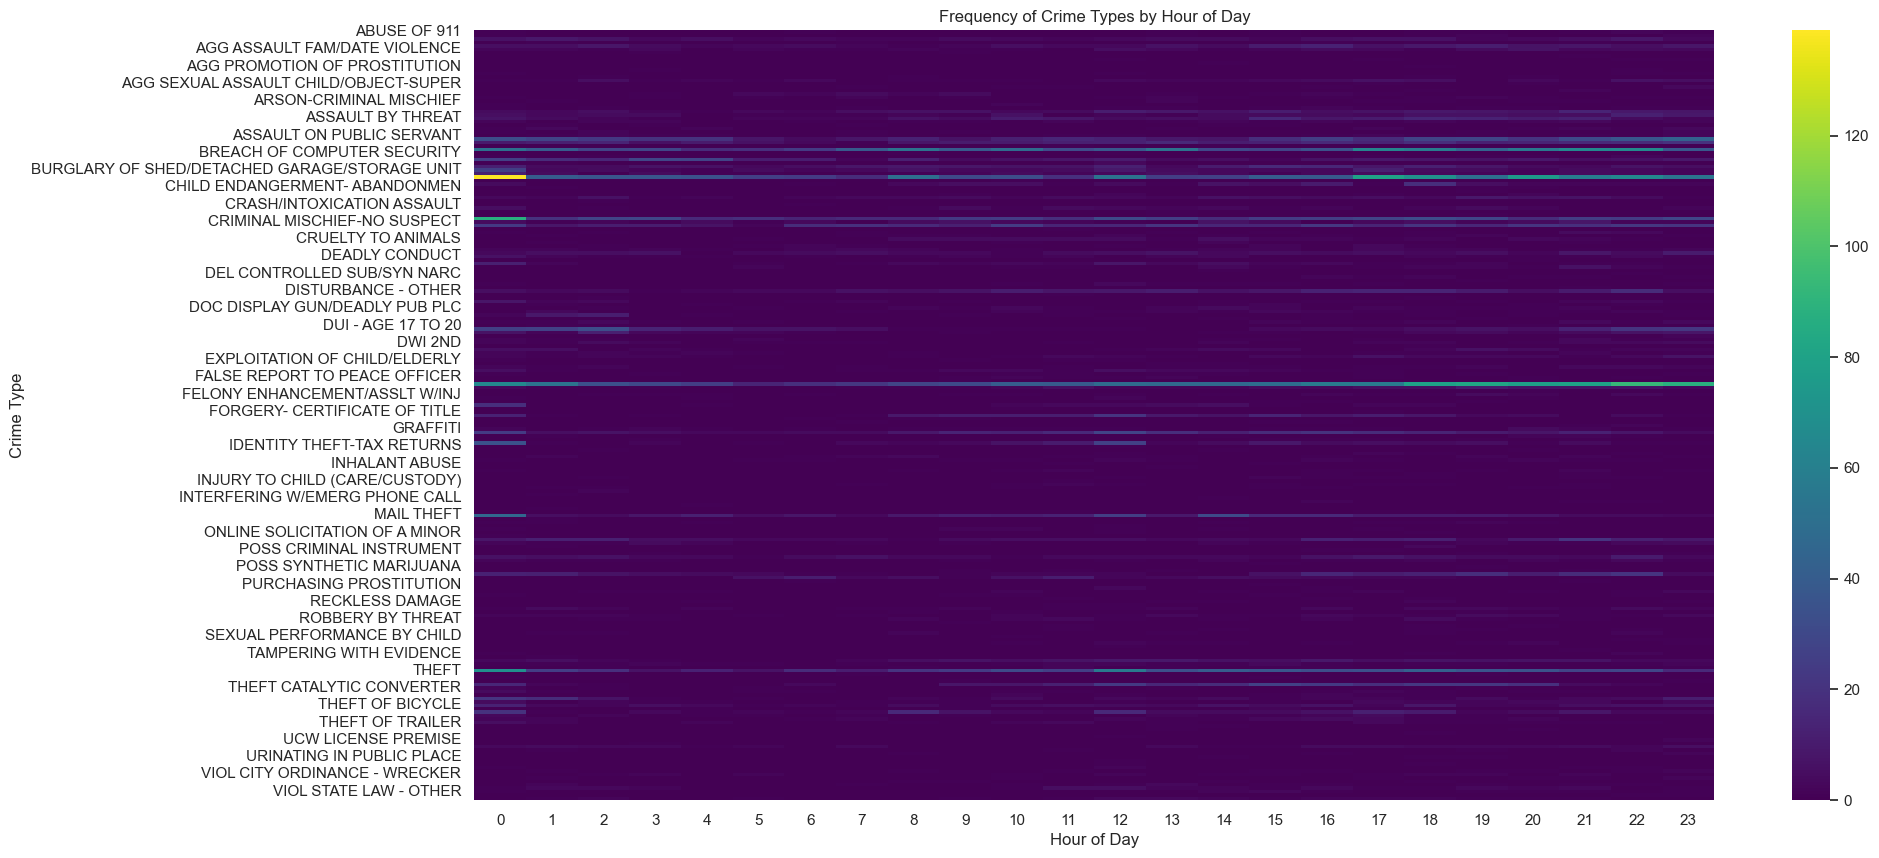

In [40]:

# Convert 'Occurred Date Time' to datetime (if not already done)
df['occurred_dt'] = pd.to_datetime(df['Occurred Date Time'], errors='coerce')

# Extract hour if not already extracted
df['Hour'] = df['occurred_dt'].dt.hour

# Group data by 'Highest Offense Description' and 'Hour' to count occurrences
crime_by_hour = df.groupby(['Highest Offense Description', 'Hour']).size().unstack(fill_value=0)

# For visualization, you can use a heatmap to show the frequency of different crimes by hour
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
sns.heatmap(crime_by_hour, cmap='viridis')
plt.title('Frequency of Crime Types by Hour of Day')
plt.ylabel('Crime Type')
plt.xlabel('Hour of Day')
plt.show()


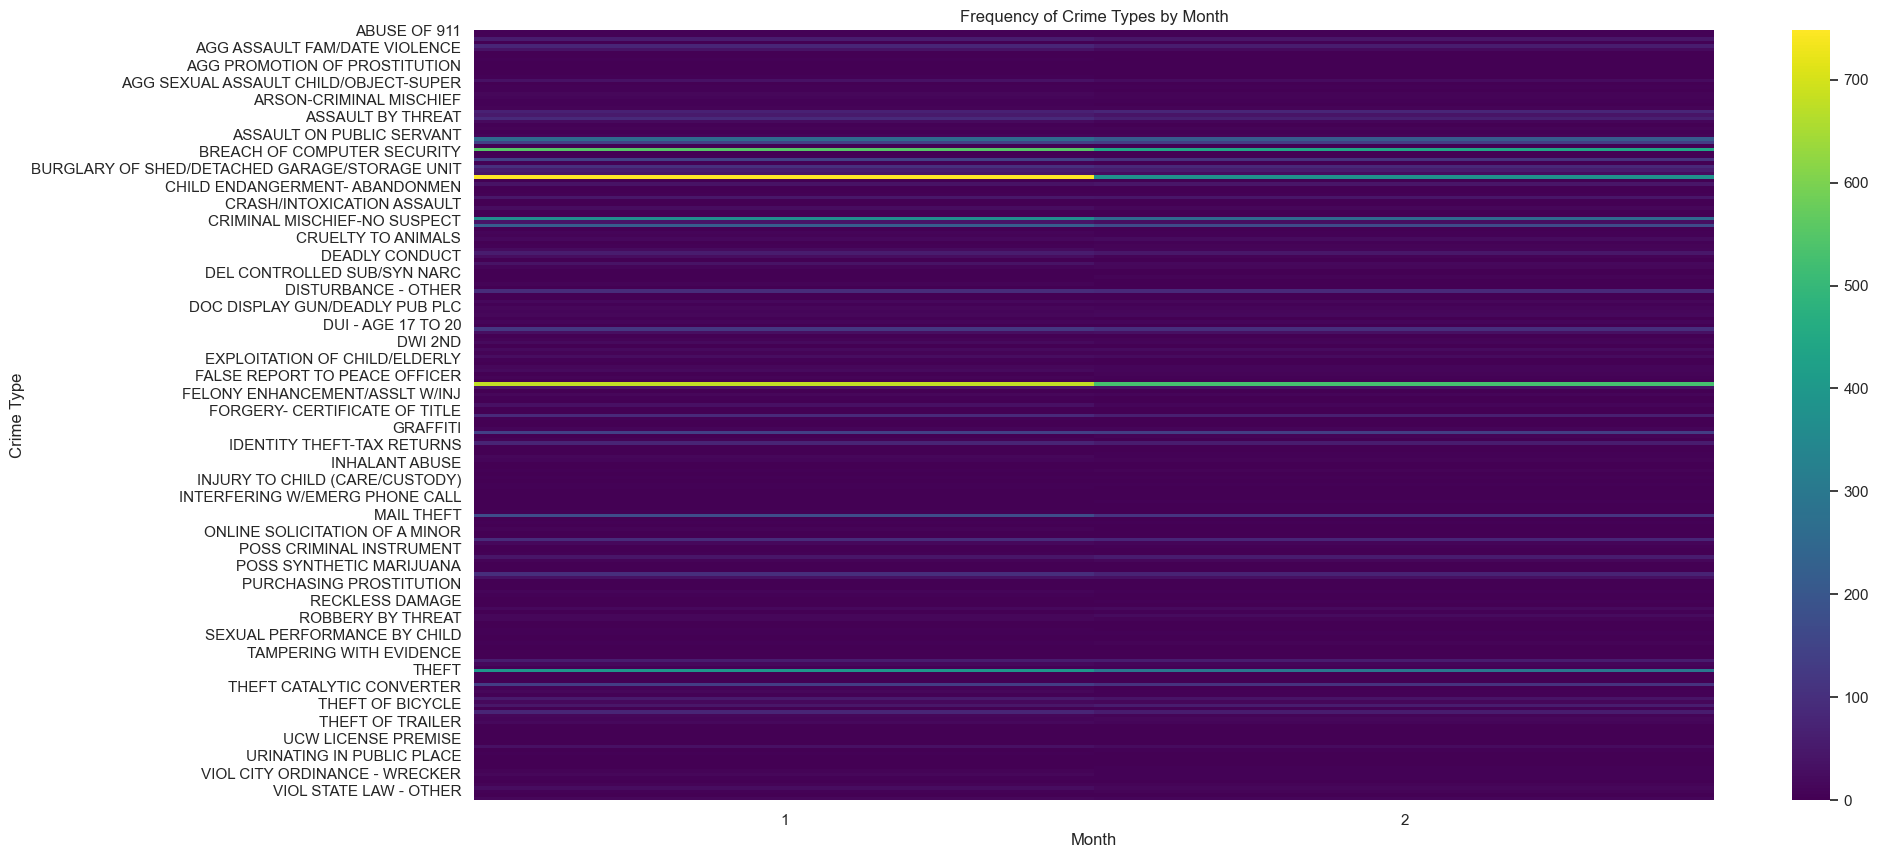

In [41]:
# Extract month if not already extracted
df['Month'] = df['occurred_dt'].dt.month

# Group data by 'Highest Offense Description' and 'Month' to count occurrences
crime_by_month = df.groupby(['Highest Offense Description', 'Month']).size().unstack(fill_value=0)

# Visualize the frequency of different crimes by month
plt.figure(figsize=(20, 10))
sns.heatmap(crime_by_month, cmap='viridis')
plt.title('Frequency of Crime Types by Month')
plt.ylabel('Crime Type')
plt.xlabel('Month')
plt.show()
